In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from collections import Counter

from utils import qubo_dict_to_matrix
from make_qubo import build_qubo
from evaluate import evaluate_solution
from utils import bitstring_to_assignment

In [2]:
qubo = build_qubo([6, 6], [324.07, 285.41], ['Panamax_A', 'NeoPanamax'])
Q = qubo_dict_to_matrix(qubo)

Q = Q + Q.T - np.diag(np.diag(Q))
Q[0,0] = -55

Q = 0.05*Q

print(Q)

[[-2.75  5.5   5.    0.  ]
 [ 5.5  -2.75  0.    2.75]
 [ 5.    0.   -2.75  5.5 ]
 [ 0.    2.75  5.5  -2.75]]


In [3]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

In [4]:
costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

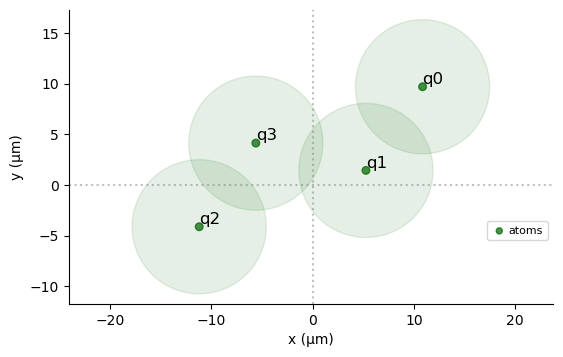

In [5]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

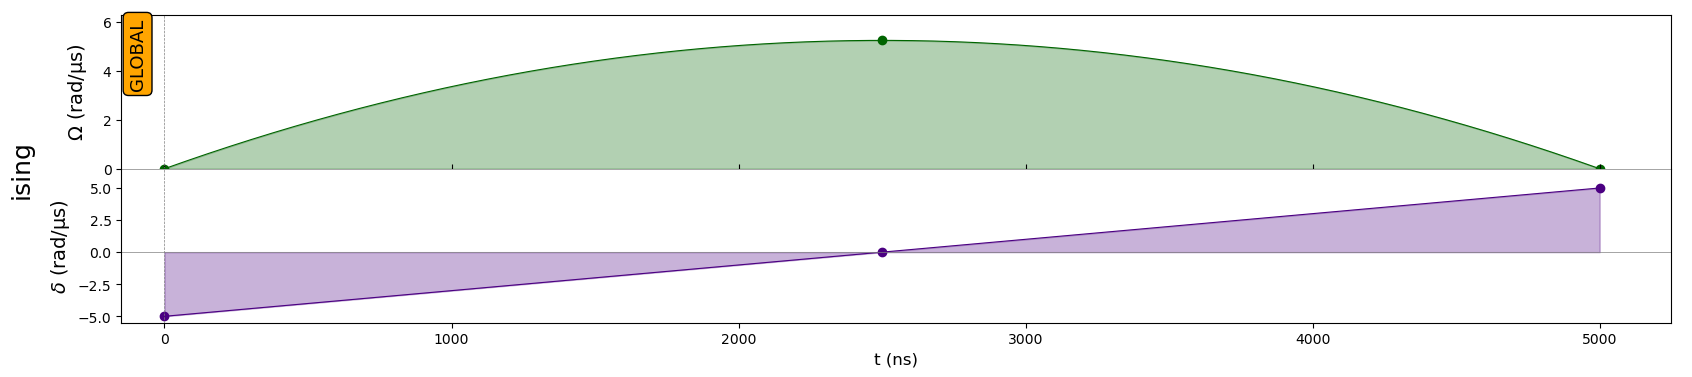

In [6]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 5000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [7]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

In [8]:
print("Measurement results:", count_dict)

Measurement results: Counter({'1010': 342, '1001': 207, '0110': 184, '1110': 62, '1011': 56, '0101': 35, '0010': 24, '1000': 24, '0100': 17, '0001': 15, '1101': 14, '0011': 6, '0000': 4, '0111': 4, '1100': 3, '1111': 3})


In [9]:
# Convert all bitstrings to their corresponding assignment dictionaries
assignments = {bit: bitstring_to_assignment(bit) for bit in count_dict}

# Example: Print out each bitstring's assignment and its count
for bit, count in count_dict.items():
    print(f"Bitstring: {bit}, Count: {count}, Assignment: {assignments[bit]}")


Bitstring: 0000, Count: 4, Assignment: {0: 0, 1: 0, 2: 0, 3: 0}
Bitstring: 0001, Count: 15, Assignment: {0: 0, 1: 0, 2: 0, 3: 1}
Bitstring: 0010, Count: 24, Assignment: {0: 0, 1: 0, 2: 1, 3: 0}
Bitstring: 0011, Count: 6, Assignment: {0: 0, 1: 0, 2: 1, 3: 1}
Bitstring: 0100, Count: 17, Assignment: {0: 0, 1: 1, 2: 0, 3: 0}
Bitstring: 0101, Count: 35, Assignment: {0: 0, 1: 1, 2: 0, 3: 1}
Bitstring: 0110, Count: 184, Assignment: {0: 0, 1: 1, 2: 1, 3: 0}
Bitstring: 0111, Count: 4, Assignment: {0: 0, 1: 1, 2: 1, 3: 1}
Bitstring: 1000, Count: 24, Assignment: {0: 1, 1: 0, 2: 0, 3: 0}
Bitstring: 1001, Count: 207, Assignment: {0: 1, 1: 0, 2: 0, 3: 1}
Bitstring: 1010, Count: 342, Assignment: {0: 1, 1: 0, 2: 1, 3: 0}
Bitstring: 1011, Count: 56, Assignment: {0: 1, 1: 0, 2: 1, 3: 1}
Bitstring: 1100, Count: 3, Assignment: {0: 1, 1: 1, 2: 0, 3: 0}
Bitstring: 1101, Count: 14, Assignment: {0: 1, 1: 1, 2: 0, 3: 1}
Bitstring: 1110, Count: 62, Assignment: {0: 1, 1: 1, 2: 1, 3: 0}
Bitstring: 1111, Count: 3,

In [ ]:
# Evaluate Solutions with highest count
print(evaluate_solution({0: 1, 1: 0, 2: 1, 3: 0}, [6, 6], [324.07, 285.41], ['Panamax_A', 'NeoPanamax']))
print(evaluate_solution({0: 1, 1: 0, 2: 0, 3: 1}, [6, 6], [324.07, 285.41], ['Panamax_A', 'NeoPanamax']))
print(evaluate_solution({0: 0, 1: 1, 2: 1, 3: 0}, [6, 6], [324.07, 285.41], ['Panamax_A', 'NeoPanamax']))

(100, 30, 130, 200, 1, 0, ['Time slot 0 exceeds lock length by 315.48 meters'])
(145, 75, 130, 200, 0, 0, ['Time slot 0 exceeds lock length by 30.069999999999993 meters'])
(-55, 75, 130, 0, 0, 0, [])


## Adiabatic Time Analysis

In [11]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())

In [12]:
cost = []
for T in 1000 * np.linspace(1, 10, 10):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost.append(get_cost(count_dict, Q) / 3)

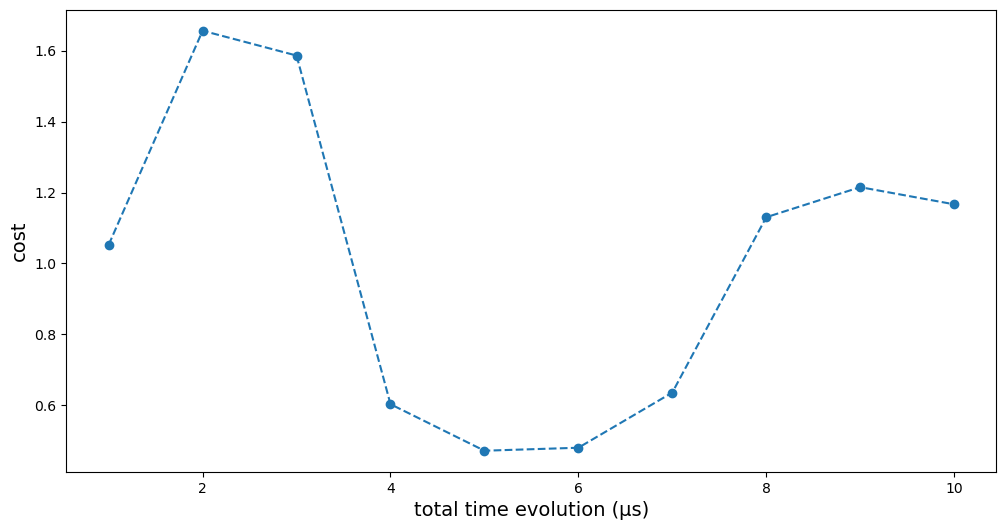

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), np.array(cost), "--o")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.show()